# Modelo para predição do sucesso de Start-Ups

Esse nootebook apresenta um modelo preditivo que utiliza o random forest com hiperparâmetros ajustados para estimar o sucesso de startups a partir de informações históricas de captação de recursos, milestones, relacionamentos, setor de atuação e localização.  

### 1. Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn as sk
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

print("Bibliotecas importadas com sucesso:","\n Pandas - ", pd.__version__, "\n NumPy -", np.__version__, "\n Matplotlib", "\n Seaborn -", sns.__version__, "\n Scikit-learn -", sk.__version__)

Bibliotecas importadas com sucesso: 
 Pandas -  2.3.2 
 NumPy - 2.3.3 
 Matplotlib 
 Seaborn - 0.13.2 
 Scikit-learn - 1.7.2


### 2. Carregamento do dataset

In [2]:
df = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')

numero_de_linhas = len(df)
numero_de_colunas = len(df.columns)

numero_de_linhas_teste = len(df_test)
numero_de_colunas_teste = len(df_test.columns)

print(f"O DataFrame de treino tem {numero_de_linhas} linhas(Start-up) e {numero_de_colunas} colunas(feature).")
print(f"O DataFrame de teste tem {numero_de_linhas_teste} linhas (Start-up) e {numero_de_colunas_teste} colunas(feature).")


O DataFrame de treino tem 646 linhas(Start-up) e 33 colunas(feature).
O DataFrame de teste tem 277 linhas (Start-up) e 32 colunas(feature).


### 3. Limpeza e Tratamento de Valores Nulos (até 0,5 pt)
Abaixo está documentado todo o processo de limpeza e tratamento realizados em ambos os datasets: "train" e "test".

**3.1 Lidando com valores nulos (NaN)**

Durante o pré-processamento, foi necessário tratar os valores nulos de forma cuidadosa para não perder informações relevantes. No caso das variáveis age_* , a ausência de valor não significa simplesmente dado perdido, mas sim que o evento de funding ou milestone nunca aconteceu, o que pode impactar diretamente o sucesso da startup.\
Nesse sentido, o tratamento consistiu na substituição dos valores ausentes pela mediana da coluna, acompanhada da criação de colunas auxiliares (*_missing) que sinalizam a ausência original. Assim, cada observação passou a conter tanto um valor numérico válido (evitando problemas de compatibilidade com os algoritmos) quanto uma flag que preserva a informação semântica de “evento inexistente” (por exemplo, startups que nunca receberam funding ou não registraram milestones). Essa estratégia permite ao modelo utilizar simultaneamente a magnitude imputada e a ausência como fatores explicativos, ampliando a capacidade preditiva e evitando perda de padrões relevantes.

In [3]:
# Colunas que precisam de imputação + flag
age_cols = [
    "age_first_funding_year", 
    "age_last_funding_year", 
    "age_first_milestone_year", 
    "age_last_milestone_year"
]

# Train

df_imputed = df.copy()

for col in age_cols:
    # Criar flag de ausência
    df_imputed[f"{col}_missing"] = df_imputed[col].isna().astype(int)
    # Preencher com a mediana
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())

# Test

df_test_imputed = df_test.copy()

for col in age_cols:
    # Criar flag de ausência
    df_test_imputed[f"{col}_missing"] = df_test_imputed[col].isna().astype(int)
    # Preencher com a mediana
    df_test_imputed[col] = df_test_imputed[col].fillna(df_test_imputed[col].median())


# Conferir resultado
print(df_imputed[age_cols + [f"{col}_missing" for col in age_cols]].head())
print(df_test_imputed[age_cols + [f"{col}_missing" for col in age_cols]].head())

   age_first_funding_year  age_last_funding_year  age_first_milestone_year  \
0                   10.42                  13.09                     8.980   
1                    3.79                   3.79                     2.785   
2                    0.71                   2.28                     1.950   
3                    3.00                   5.00                     9.620   
4                    0.66                   5.88                     6.210   

   age_last_milestone_year  age_first_funding_year_missing  \
0                    12.72                               0   
1                     4.62                               0   
2                     2.28                               0   
3                    10.39                               0   
4                     8.61                               0   

   age_last_funding_year_missing  age_first_milestone_year_missing  \
0                              0                                 0   
1                 

**3.2 Transformação logarítmica em `funding_total_usd`**

A variável tem distribuição altamente assimétrica pois seus valores variam de milhares a bilhões. Para reduzir essa distorção e tornar os dados mais adequados à modelagem, apliquei a transformação logarítmica, criando a coluna funding_total_usd_log. Esse procedimento mantém a ordem relativa entre os valores, mas comprime a escala, diminuindo o impacto de outliers e facilitando o aprendizado do modelo.

In [4]:
# Train 
df_imputed["funding_total_usd_log"] = np.log1p(df_imputed["funding_total_usd"])

# Test
df_test_imputed["funding_total_usd_log"] = np.log1p(df_test_imputed["funding_total_usd"])

# Conferir
print(df_imputed[["funding_total_usd", "funding_total_usd_log"]].head())
print(df_test_imputed[["funding_total_usd", "funding_total_usd_log"]].head())

   funding_total_usd  funding_total_usd_log
0            4087500              15.223444
1           45000000              17.622173
2            5200000              15.464169
3           14500000              16.489659
4           70000000              18.064006
   funding_total_usd  funding_total_usd_log
0           11489687              16.256960
1            3170000              14.969242
2           47218498              17.670296
3           15000000              16.523561
4           52000000              17.766754


### 4. Codificação de Variáveis Categóricas (até 0,5 pt)

**One-Hot Encoding em `category_code`**

Transformei a variável category_code, de natureza categórica nominal, em novas colunas binárias para cada um dos setores (ex.: cat_software, cat_health) por meio do One-Hot Encoding. Essa escolha foi feita para garantir que o modelo interprete corretamente os setores de atuação, evitando que o algoritmo imponha uma ordem inexistente entre categorias. Nesse sentido, o OHE assegura maior consistência e transparência na representação dos dados, ainda que aumente o número de variáveis no dataset.

In [5]:
# Aplicar One-Hot Encoding em category_code do dataset de treino
df_encoded = pd.get_dummies(df_imputed, columns=["category_code"], prefix="cat", drop_first=False)

# Aplicar One-Hot Encoding em category_code do dataset de teste
df_test_encoded = pd.get_dummies(df_test_imputed, columns=["category_code"], prefix="cat", drop_first=False)

# Garantir que ambos os datasets tenham as mesmas colunas após OHE
df_test_encoded = df_test_encoded.reindex(columns=df_encoded.columns, fill_value=0)

# Conferir resultado
print("Número total de colunas após OHE no dataset de treino:", df_encoded.shape[1])
print("Número total de colunas após OHE no dataset de teste:", df_test_encoded.shape[1])


Número total de colunas após OHE no dataset de treino: 71
Número total de colunas após OHE no dataset de teste: 71


### 5. EDA: Exploração e Visualização dos Dados (até 2,0 pts)

Essa análise exploratória teve como objetivo descobrir padrões, correlações e tendências nos dados.

**5.1 Target**

O dataset é moderadamente desbalanceado o que significa que, se um modelo previsse sempre “sucesso”, ele já teria 64,7% de acurácia, e isso sinaliza a importância de olhar também para as métricas de precisão, recall e F1.

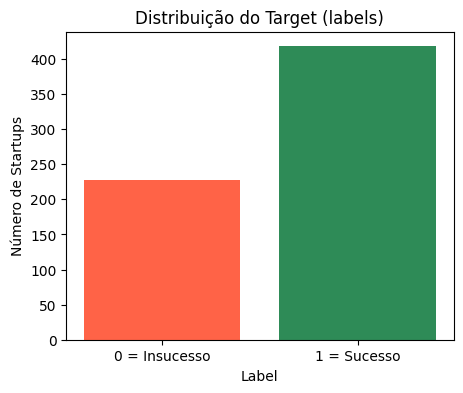

0 (insucesso): 228 startups (~35.3%)
1 (sucesso): 418 startups (~64.7%)


In [6]:
# Contagem de cada classe
class_counts = df['labels'].value_counts().sort_index()

# Plot do gráfico
plt.figure(figsize=(5,4))
plt.bar(class_counts.index.astype(str), class_counts.values, color=['tomato','seagreen'])
plt.title("Distribuição do Target (labels)")
plt.xlabel("Label")
plt.ylabel("Número de Startups")
plt.xticks([0,1], ["0 = Insucesso", "1 = Sucesso"])
plt.show()

total = len(df)
print(f"0 (insucesso): {class_counts[0]} startups (~{class_counts[0]/total:.1%})")
print(f"1 (sucesso): {class_counts[1]} startups (~{class_counts[1]/total:.1%})")

**5.2 Tempo até a primeira captação**

Os gráficos mostram que a maioria das startups consegue captar o primeiro investimento nos primeiros cinco anos de vida, com poucos casos tardios que se configuram como outliers.

Text(0, 0.5, 'Número de startups')

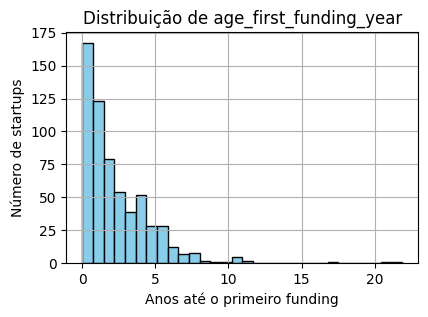

In [7]:
col = "age_first_funding_year"

plt.figure(figsize=(10,3))

# Histograma geral
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o primeiro funding")
plt.ylabel("Número de startups")


**5.3 Tempo até a última captação**


A análise da variável `age_last_funding_year` mostra que a maior parte das startups realizou sua última rodada de investimento também nos primeiros anos de vida, mas a cauda da distribuição é longa, indicando que algumas empresas captam por muitos anos.

Text(0, 0.5, 'Número de startups')

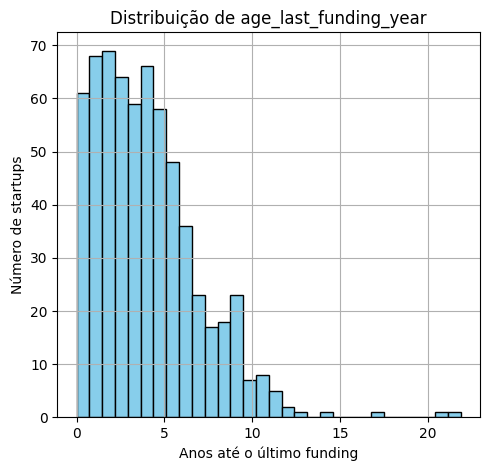

In [8]:
col = "age_last_funding_year"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o último funding")
plt.ylabel("Número de startups")


**5.4 Análise entre target e tempo até o primeiro milestone**

A análise de `age_first_milestone_year` mostra que a maior parte das startups atinge seu primeiro marco relevante ainda nos primeiros anos de operação, embora exista uma cauda longa indicando que algumas só conquistam milestones mais tarde.

Text(0, 0.5, 'Número de startups')

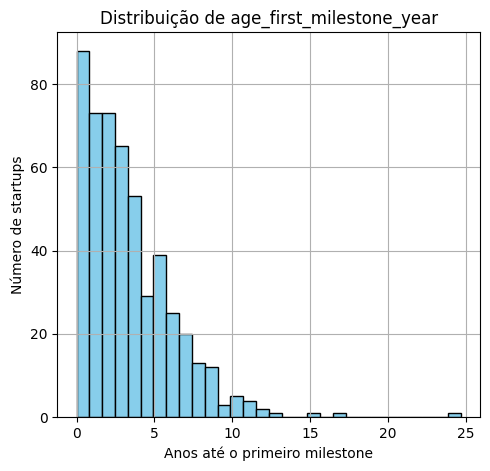

In [9]:
col = "age_first_milestone_year"

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o primeiro milestone")
plt.ylabel("Número de startups")


**5.5 Tempo até o último milestone**

A análise de `age_last_milestone_year` mostra que a maioria das startups registra seu último milestone dentro dos primeiros anos de operação, mas há casos em que esses eventos ocorrem em fases bem mais avançadas, criando uma cauda longa na distribuição.

Text(0, 0.5, 'Número de startups')

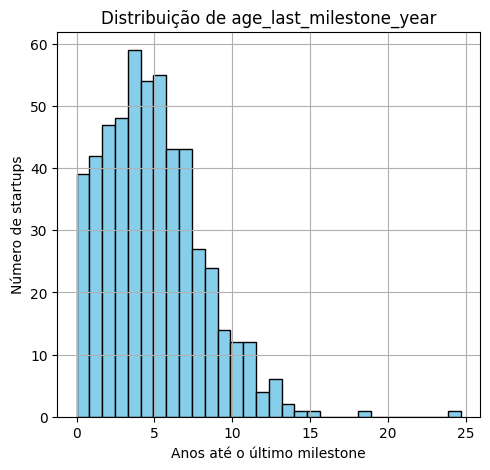

In [10]:
col = "age_last_milestone_year"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Anos até o último milestone")
plt.ylabel("Número de startups")


**5.6 Quantidade de conexões (relationship)**

A análise mostra que a maioria das startups possui um número relativamente baixo de conexões (fundadores, executivos e investidores), mas existem alguns casos extremos com dezenas de relacionamentos, configurando outliers na distribuição.

Text(0, 0.5, 'Número de startups')

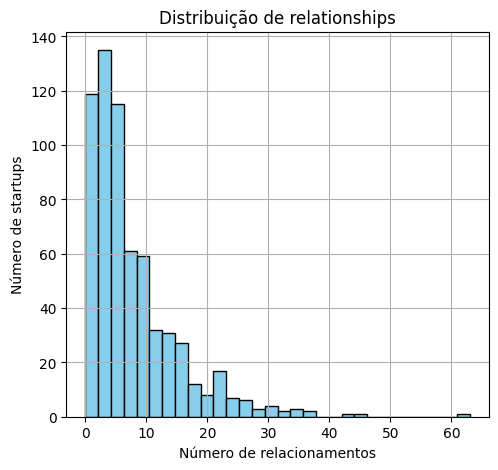

In [11]:
col = "relationships"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=30, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de relacionamentos")
plt.ylabel("Número de startups")


**5.7 Quantidade de rodadas de investimento**

A maioria das startups passa por poucas rodadas de captação, concentrando-se entre uma e três rodadas, enquanto apenas algumas alcançam um número elevado, funcionando como outliers.

Text(0, 0.5, 'Número de startups')

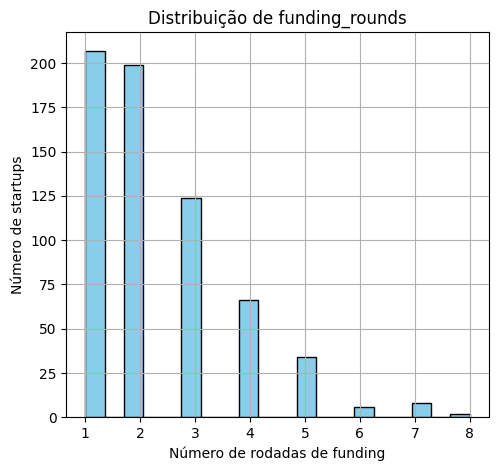

In [12]:
col = "funding_rounds"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de rodadas de funding")
plt.ylabel("Número de startups")

**5.8 Contagem de marcos relevantes**

A maioria das startups possui apenas alguns marcos registrados (em torno de 1 a 3), enquanto poucas acumulam um número muito maior, configurando outliers.

Text(0, 0.5, 'Número de startups')

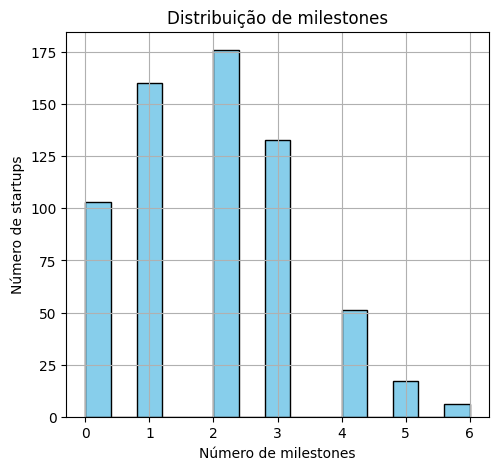

In [13]:
col = "milestones"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=15, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Número de milestones")
plt.ylabel("Número de startups")


**5.9 Média de investidores por rodada**

A maioria das startups atrai poucos investidores por rodada, com a distribuição concentrada em valores baixos, mas existem casos em que a média é significativamente maior, formando outliers.

Text(0, 0.5, 'Número de startups')

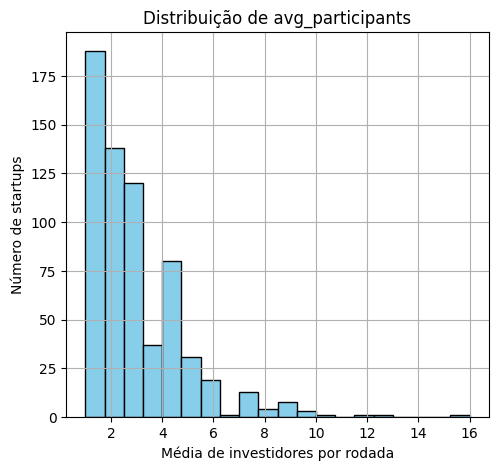

In [14]:
col = "avg_participants"

plt.figure(figsize=(12,5))

# Histograma geral (coluna 1)
plt.subplot(1,2,1)
df[col].hist(bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribuição de {col}")
plt.xlabel("Média de investidores por rodada")
plt.ylabel("Número de startups")


**5.10 Localidade**

Startups sediadas na Califórnia (is_CA), Nova Iorque (is_NY) e Massachusetts (is_MA)estão bem representados no dataset. Já Texas (is_TX) e a categoria outros estados (is_otherstate) possuem menos representantes.

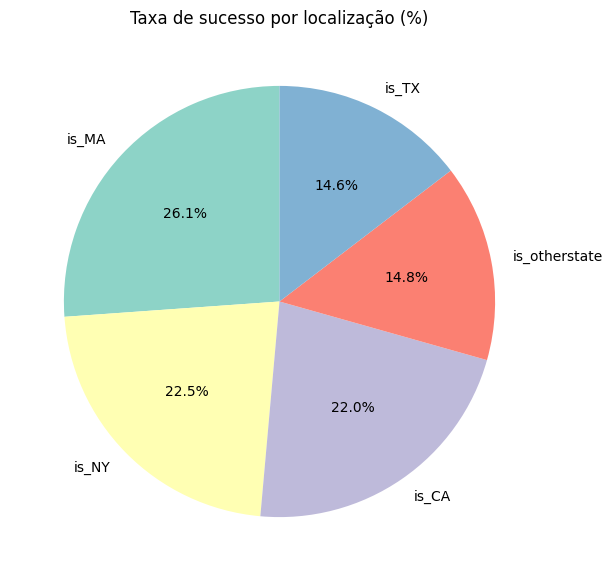

In [15]:
# Lista das variáveis de localização
loc_cols = ["is_CA", "is_NY", "is_MA", "is_TX", "is_otherstate"]

# Calcular a taxa de sucesso (labels=1) em cada estado
success_rates = {}
for col in loc_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame para facilitar o plot
loc_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=False)

# Gráfico de pizza
plt.figure(figsize=(7,7))
plt.pie(
    loc_success["taxa_sucesso"], 
    labels=loc_success.index, 
    autopct="%.1f%%", 
    startangle=90,
    colors=plt.cm.Set3.colors
)
plt.title("Taxa de sucesso por localização (%)")
plt.show()



**5.11 Setor**

Apesar de pequenas variações entre categorias, a maioria dos setores apresenta taxas de sucesso relativamente próximas, geralmente entre 60% e 80%.

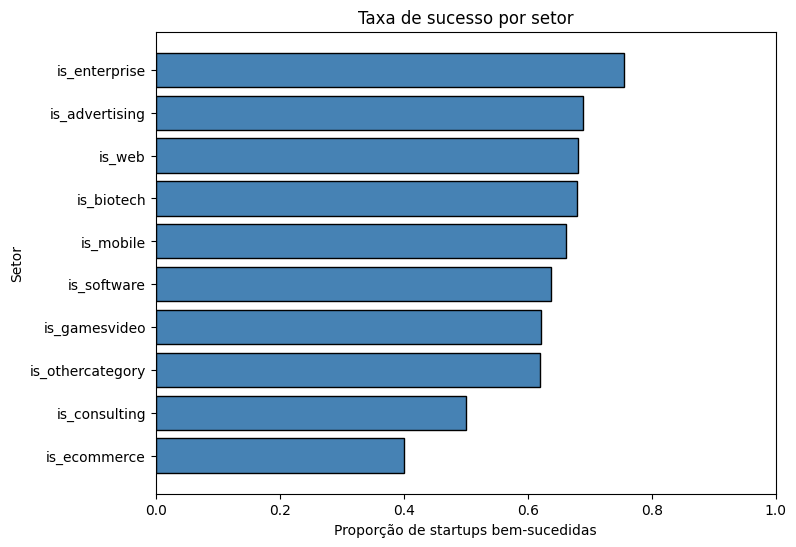

In [16]:

# Lista das variáveis de setor/mercado
sector_cols = [
    "is_software", "is_web", "is_mobile", "is_enterprise", "is_advertising",
    "is_gamesvideo", "is_ecommerce", "is_biotech", "is_consulting", "is_othercategory"
]

# Calcular a taxa de sucesso (labels=1) em cada setor
success_rates = {}
for col in sector_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame
sector_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(8,6))
plt.barh(sector_success.index, sector_success["taxa_sucesso"], color="steelblue", edgecolor="black")
plt.title("Taxa de sucesso por setor")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Setor")
plt.xlim(0,1)
plt.show()


**5.12 Tpo de financiamento**

Startups que receberam venture capital ou avançaram para rodadas como Série B, C ou D apresentam taxas de sucesso mais altas, indicando tração e confiança do mercado. Já aquelas que pararam em fases iniciais, como apenas investimento anjo ou até a Série A, têm taxas menores.

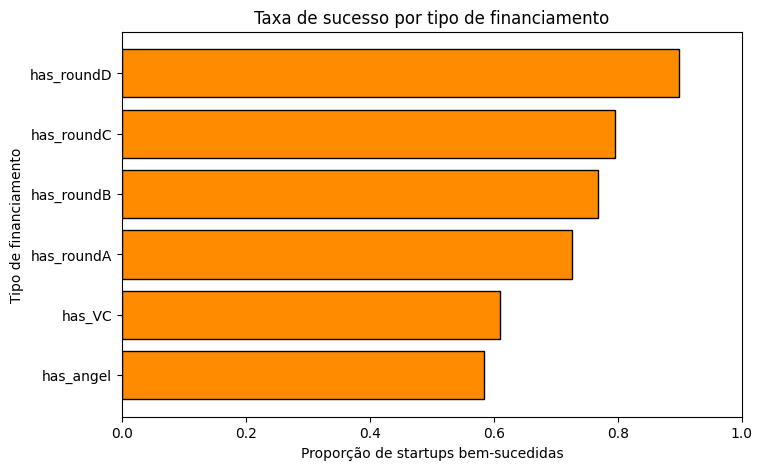

In [17]:

# Lista das variáveis de financiamento
funding_cols = ["has_VC", "has_angel", "has_roundA", "has_roundB", "has_roundC", "has_roundD"]

# Calcular a taxa de sucesso (labels=1) em cada tipo de funding
success_rates = {}
for col in funding_cols:
    taxa = df.loc[df[col] == 1, "labels"].mean()
    success_rates[col] = taxa

# Converter em DataFrame
funding_success = pd.DataFrame.from_dict(success_rates, orient="index", columns=["taxa_sucesso"]).sort_values(by="taxa_sucesso", ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(8,5))
plt.barh(funding_success.index, funding_success["taxa_sucesso"], color="darkorange", edgecolor="black")
plt.title("Taxa de sucesso por tipo de financiamento")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Tipo de financiamento")
plt.xlim(0,1)
plt.show()

**5.13 Categorias**

A taxa de sucesso das startups é relativamente homogênea entre os setores, com a maioria variando entre 0.6 e 0.8, o que sugere que o setor de atuação, isoladamente, não é um fator determinante para o sucesso.  
Vale destacar que as categorias sports, transportation, education, health e music apresentaram 100% de sucesso, mas esses resultados devem ser interpretados com cautela uma vez que eles possuem poucos representantes na base de dados, dessa forma eles representam um risco de overfitting, já que o modelo pode aprender uma regra que não se generaliza fora da amostra.
Assim, o setor pode ser considerado uma variável de baixa relevância preditiva isolada, servindo mais como complemento quando combinada a outras características.

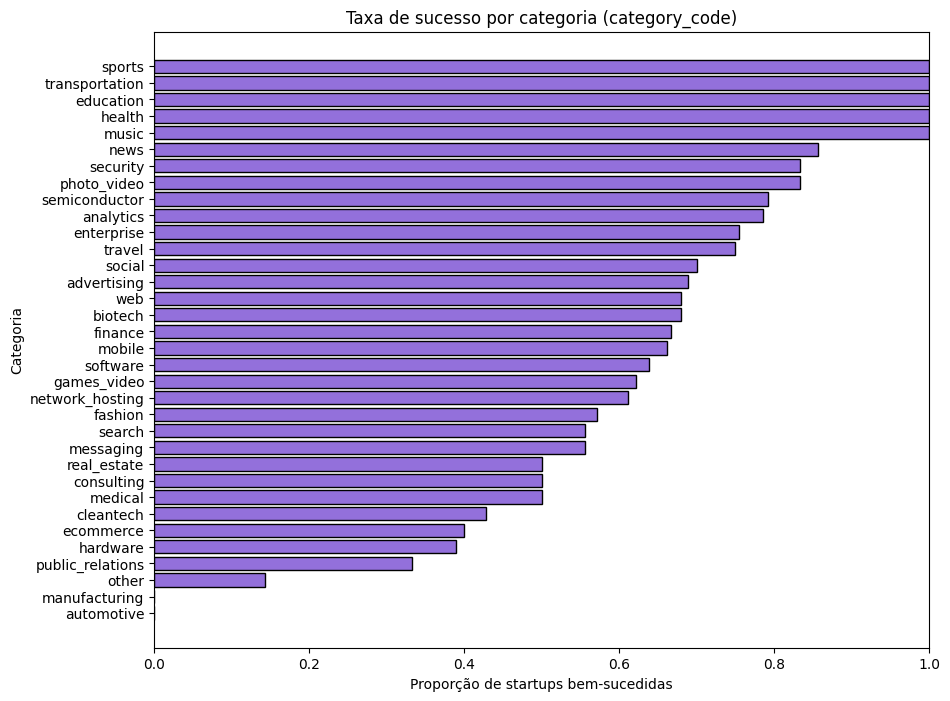

In [18]:

col = "category_code"

# Calcular a taxa de sucesso média por categoria
category_success = df.groupby(col)["labels"].mean().sort_values(ascending=True)

# Gráfico de barras horizontais
plt.figure(figsize=(10,8))
plt.barh(category_success.index, category_success.values, color="mediumpurple", edgecolor="black")
plt.title("Taxa de sucesso por categoria (category_code)")
plt.xlabel("Proporção de startups bem-sucedidas")
plt.ylabel("Categoria")
plt.xlim(0,1)
plt.show()


- confirmar se os 100% de sucesso nos setores sports, transportation, education, health e music são de fato robustos ou apenas ruído por terem poucas startups

In [19]:
# Setores de interesse
setores = ["sports", "transportation", "education", "health", "music"]

# Contagem de startups nesses setores
category_counts = df[df["category_code"].isin(setores)]["category_code"].value_counts()

print(category_counts)


category_code
music             5
health            2
education         2
transportation    2
sports            1
Name: count, dtype: int64


A análise desses setores mostra que como há baixa quantidade de representantes nessas áreas. Dessa forma, existe risco de overfitting, já que o modelo pode aprender uma regra que não se generaliza fora da amostra.

### 6. Formulação de Hipóteses (até 1,0 pt)

Formulação de três hipóteses que possam explicar os fatores que influenciam o sucesso da empresas.

**Hipótese 1: Startups bem-sucedidas tendem a captar mais cedo**

Justificativa

- A velocidade com que uma startup consegue captar seu primeiro investimento pode ser indicativo da atratividade do negócio, a experiência do time fundador e a confiança dos investidores. Se de fato as startups bem-sucedidas captam mais cedo, esse comportamento pode ser usado como uma variável importante no modelo preditivo.

Hipóteses

- H0 (Hipótese Nula): Não existe relação entre o tempo até o primeiro funding e a probabilidade de sucesso da startup.
- Ha (Hipótese Alternativa): Existe relação entre o tempo até o primeiro funding e a probabilidade de sucesso da startup.

Interpretação

- Se startups de sucesso tiverem valores médios de tempo até o primeiro funding menores do que startups que fecharam, então podemos concluir que captar mais cedo está associado ao sucesso.

Análise

- A análise compara a distribuição do tempo até o primeiro funding (age_first_funding_year) entre startups bem-sucedidas e as que não são bem-sucedidas. Caso o tempo médio das bem-sucedidas seja menor, isso apoiará a hipótese.

Resultado

- Tempo médio até o primeiro funding (sucesso = 1): 2.1 anos

- Tempo médio até o primeiro funding (insucesso = 0): 2.7 anos

Resultado para H0 e Ha

- Rejeitamos H0 e aceitamos Ha. Os dados mostram que startups bem-sucedidas tendem a captar mais cedo, reforçando a hipótese de que a velocidade de captação é um fator associado ao sucesso.
Além disso, ao comparar sucesso e insucesso, percebe-se que startups bem-sucedidas tendem a captar mais cedo, com valores mais concentrados em idades menores, enquanto as de insucesso apresentam distribuição mais espalhada, sugerindo que o tempo até o primeiro funding é um fator relevante e que captar cedo está associado a maiores chances de sucesso.

Média e Mediana por grupo (0 = insucesso, 1 = sucesso):

            mean  median
labels                  
0       2.707190   1.775
1       2.150324   1.590


Text(0, 0.5, 'Anos até o primeiro funding')

<Figure size 1000x300 with 0 Axes>

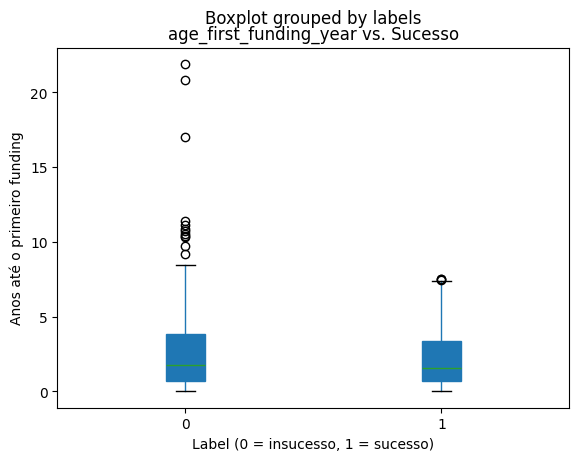

In [20]:
# Calcular média e mediana do tempo até o primeiro funding por label
stats = df.groupby("labels")["age_first_funding_year"].agg(["mean", "median"])

print("Média e Mediana por grupo (0 = insucesso, 1 = sucesso):\n")
print(stats)

# Plotar gráfico
col = "age_first_funding_year"

plt.figure(figsize=(10,3))

df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o primeiro funding")

**Hipótese 2: Startups bem-sucedidas conseguiram consolidar rodadas significativas de investimento relativamente cedo**

Justificativa

- A consolidação de rodadas de investimento em fases iniciais é um sinal de tração e confiança do mercado. Startups que atraem funding relevante mais cedo tendem a ter recursos e credibilidade para sustentar seu crescimento.

Hipóteses

- H0 (Hipótese Nula): Não existe relação entre o tempo das rodadas de investimento e a probabilidade de sucesso da startup.
- Ha (Hipótese Alternativa): Existe relação entre o tempo das rodadas de investimento e a probabilidade de sucesso da startup.

Interpretação

- Se startups bem-sucedidas apresentam concentrações de funding em períodos mais iniciais/medianos, enquanto as que não são bem sucedidas têm maior dispersão, então podemos concluir que consolidar funding cedo está associado ao sucesso.

Análise

- A análise evidencia que captar cedo e de forma consistente acelera o crescimento, aumenta a confiança de investidores e sustenta a competitividade no mercado.

Resultado para H0 e Ha

- No boxplot, percebe-se que startups de sucesso tendem a concentrar seus últimos fundings em períodos mais iniciais e medianos, enquanto as de insucesso apresentam maior dispersão e alguns casos extremos. Isso sugere que, embora seja possível captar em fases avançadas, a tendência é que startups bem-sucedidas tenham conseguido consolidar rodadas significativas relativamente cedo. Portanto, rejeitamos H0 e aceitamos Ha: consolidar funding em fases iniciais está associado a maiores chances de sucesso.

Text(0, 0.5, 'Anos até o último funding')

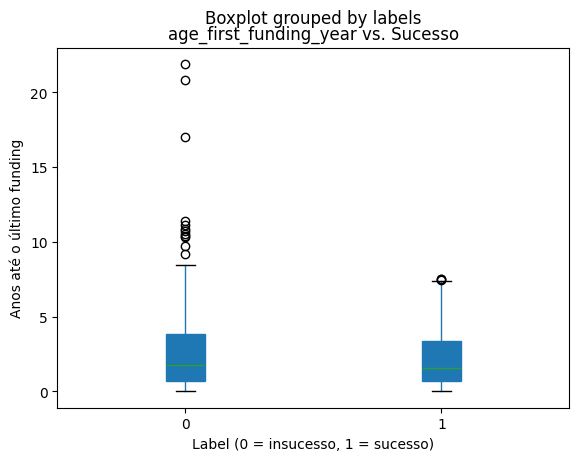

In [21]:
# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o último funding")

**Hipótese 3: Startups de sucesso tendem a alcançar milestones de forma mais precoce**

Justificativa

- Os milestones (como lançamentos, patentes, parcerias estratégicas ou produtos relevantes) representam conquistas importantes que validam o modelo de negócio da startup. Atingi-los mais cedo pode indicar maior eficiência operacional, execução ágil e capacidade de atrair a atenção do mercado e investidores.

Hipóteses

- H0 (Hipótese Nula): Não existe relação entre o tempo para atingir milestones e a probabilidade de sucesso da startup.
- Ha (Hipótese Alternativa): Existe relação entre o tempo para atingir milestones e a probabilidade de sucesso da startup.

Interpretação

- Se startups bem-sucedidas alcançam milestones mais cedo (valores menores em age_first_milestone_year), então isso sugere que atingir marcos precocemente está associado a maiores chances de sucesso.

Análise

- A análise reflete a capacidade da start-up de transformar ideias em resultados concretos rapidamente e transmitindo confiança ao mercado.

Resultado para H0 e Ha

- O boxplot mostra que startups de sucesso tendem a atingir milestones em períodos mais precoces, enquanto as malsucedidas apresentam maior dispersão e tempos mais longos. Isso sugere que demorar muito para atingir o primeiro marco pode estar associado a menores chances de sucesso. Assim, rejeitamos H0 e aceitamos Ha: atingir milestones cedo é um sinal positivo para o futuro da startup, tornando essa variável relevante para o modelo preditivo.

Text(0, 0.5, 'Anos até o primeiro milestone')

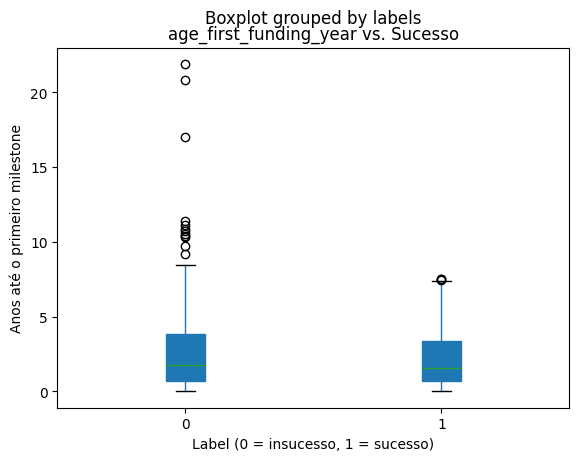

In [22]:
# Boxplot comparando sucesso x insucesso (coluna 2)
df.boxplot(column=col, by="labels", grid=False, patch_artist=True)
plt.title(f"{col} vs. Sucesso")
plt.xlabel("Label (0 = insucesso, 1 = sucesso)")
plt.ylabel("Anos até o primeiro milestone")

**Conclusões finais**  
A partir da análise exploratória e hipóteses, é possível chegar a algumas conclusões acerca de padrões que start-ups de sucesso compartilham, dentre eles: 

- Captam mais cedo e em maior quantidade, tanto em número de rodadas quanto em valor total.

- Atingem milestones mais rápido e acumulam mais marcos relevantes nos anos iniciais.

Ou seja, há uma consistência temporal e quantitativa: quanto mais cedo e mais frequentes forem os sinais de tração (fundings, milestones, investidores), maior a chance de a startup ser bem-sucedida.

### 7. Seleção de Features (até 1,0 pt)

Foi definido a variável y como a coluna alvo (labels) e as demais colunas (exeto "labels", "id" e "funding_total_usd"), como nosso X (features preditoras).  

Durante esta etapa, apliquei a função `train_test_split`, reservando 20% dos dados para teste (cerca de 130 startups) e 80% para treino (cerca de 516 startups)e defini o parâmetro stratify=y para manter a mesma proporção de sucesso e insucesso nas duas amostras, garantindo representatividade.

In [ ]:
# Colunas a remover
cols_to_drop = ["labels", "id", "funding_total_usd"]

# Criar variáveis
X = df_encoded.drop(columns=cols_to_drop, errors="ignore")
y = df_encoded["labels"]

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        
    stratify=y,           
    random_state=42       
)


### 8. Construção e Avaliação do Modelo (até 2,0 pts)

O modelo de machine learning que escolhi foi o Random Forest, por conta de sua robustez, capacidade de lidar com variáveis categóricas e numéricas, resistência a overfitting.

In [ ]:

# Definir o modelo Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,      
    max_depth=20,          
    min_samples_split=5,   
    min_samples_leaf=2,    
    class_weight=None,     
    random_state=42,
    n_jobs=-1
)

# Treinar
rf_model.fit(X_train, y_train)

# Avaliar no conjunto de validação (X_test, y_test)
y_pred = rf_model.predict(X_test)

# Avaliar desempenho
print("Relatório de classificação - Random Forest:\n")
print(classification_report(y_test, y_pred))



Relatório de classificação - Random Forest:

              precision    recall  f1-score   support

           0       0.71      0.52      0.60        46
           1       0.77      0.88      0.82        84

    accuracy                           0.75       130
   macro avg       0.74      0.70      0.71       130
weighted avg       0.75      0.75      0.74       130



Nos resultados de validação, a acurácia geral foi de 75%, o que significa que, em média, três a cada quatro previsões foram corretas. A precision da classe 1 (0.77) mostra que a maioria dos casos previstos como positivos são verdadeiros positivos, reduzindo falsos positivos. Já o recall da classe 1 (0.88) indica que o modelo conseguiu identificar quase todos os positivos verdadeiros, o que é essencial para não deixar escapar casos relevantes. O f1-score da classe 1 (0.82) demonstra um bom equilíbrio entre precisão e cobertura.

No geral, o modelo mostra-se adequado para o objetivo, pois consegue manter alta capacidade de identificação da classe positiva (recall), sem perder muita precisão, entregando um desempenho consistente, mas que ainda pode ser aprimorado.

### 9. Finetuning de Hiperparâmetros (até 1,0 pt)

Para aprimorar o desempenho do modelo, apliquei uma busca de hiperparâmetros com o RandomizedSearchCV, explorando diferentes combinações de valores relevantes para o modelo. Esse processo envolveu 50 iterações aleatórias com validação cruzada de 5 dobras, garantindo maior confiabilidade na seleção dos parâmetros.

In [25]:
# Modelo base
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Distribuição de parâmetros
param_dist = {
    "n_estimators": np.arange(100, 600, 50),
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4, 6],
    "max_features": ["sqrt", "log2", None],
    "class_weight": [None, "balanced"]
}

# RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,              # nº de combinações aleatórias
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Treinar busca
random_search.fit(X_train, y_train)

# Melhor modelo
best_rf_random = random_search.best_estimator_
print("Melhores hiperparâmetros (RandomizedSearch):", random_search.best_params_)

# Avaliar no teste
y_pred_random = best_rf_random.predict(X_test)

print("\nRelatório de classificação - Random Forest Tunado (RandomizedSearch):\n")
print(classification_report(y_test, y_pred_random))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Melhores hiperparâmetros (RandomizedSearch): {'n_estimators': np.int64(400), 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': None}

Relatório de classificação - Random Forest Tunado (RandomizedSearch):

              precision    recall  f1-score   support

           0       0.73      0.52      0.61        46
           1       0.77      0.89      0.83        84

    accuracy                           0.76       130
   macro avg       0.75      0.71      0.72       130
weighted avg       0.76      0.76      0.75       130



O melhor conjunto encontrado foi: 400 árvores, profundidade máxima de 10, min_samples_split=2, min_samples_leaf=1, max_features="sqrt" e sem balanceamento de classes. Esse ajuste levou a uma acurácia de 76%, ligeiramente superior ao modelo base, mantendo recall elevado (0.89) para a classe positiva.

# Exportação dos resultados

In [26]:
# Usar o modelo tunado para prever no dataset de teste real
y_test_pred = best_rf_random.predict(df_test_encoded.drop(columns=cols_to_drop, errors="ignore"))

submission = pd.DataFrame({
    "id": df_test["id"],
    "labels": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("Arquivo submission.csv gerado com", len(submission), "linhas.")


Arquivo submission.csv gerado com 277 linhas.
